# Solar System Views - Comets

Plot the positions of outer solar system planets and selected comets at a given viewing epoch in 2 views:
 * looking down from "above" at the projection onto the ecliptic plane (X,Y)
 * looking from the "side" along the X-axis at the projection onto the (Y,Z) plane

Uses `astroquery` to get data from the MPC and JPL Horizons databases.

In [71]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, LogLocator, NullFormatter

# astropy bits we need

from astropy.time import Time

# used for Newton-Raphson root solving for this plot

from scipy.optimize import newton

# astroquery

from astroquery.mpc import MPC
from astroquery.jplhorizons import Horizons

# suppress nuisance warnings

import warnings
warnings.filterwarnings('ignore',category=UserWarning, append=True)

## Standard Plot Format

#### Aspect Ratio

`aspect` sets the aspect ratio, width/height.  The default aspect ratio is 4:3, 1:1 for square plots, 
and 5:2 (2.5:1) for spectra, and equal aspect ratio for images and plots of Cartesian coordinates.
Use a formula instead of decimal when the result is a fraction (example: `aspect = 4.0/3.0` instead of
`aspect=1.33`).

In [72]:
# Aspect ratio
#
# Exceptions:
#    spectra use full width we use 5:2=2.5 aspect ratio
#
# graphic aspect ratio = width/height

aspect = 1.0 #16.0/9.0

#
# Don't change these unless you really need to (we never have)
#
# fPage is the horizontal fraction of the page occupied by the figure, default 1.0
#
# scaleFac is the LaTeX includegraphics scaling in units of \textwidth, default 1.0
#

fPage = 1.0
scaleFac = 1.0

# Text width in inches - don't change, this is defined by the print layout

textWidth = 6.0 # inches

# Graphic dimensions depending on bitmap or vector format (draft vs production)

figFmt = 'png'
dpi = 600
plotWidth = dpi*fPage*textWidth
plotHeight = plotWidth/aspect
axisFontSize = 10
labelFontSize = 7
lwidth = 0.5
axisPad = 5
wInches = fPage*textWidth # float(plotWidth)/float(dpi)
hInches = wInches/aspect  # float(plotHeight)/float(dpi)

# LaTeX is used throughout for markup of symbols, Times-Roman serif font

plt.rc('text', usetex=True)
plt.rc('font', **{'family':'serif','serif':['Times-Roman'],'weight':'bold','size':'16'})

# Font and line weight defaults for axes

matplotlib.rc('axes',linewidth=lwidth)
matplotlib.rcParams.update({'font.size':axisFontSize})

# axis and label padding

plt.rcParams['xtick.major.pad']=f'{axisPad}'
plt.rcParams['ytick.major.pad']=f'{axisPad}'
plt.rcParams['axes.labelpad'] = f'{axisPad}'

## convenience functions

a_pq(a_p,p,q) = semi-major axis of a p:q resonance for perturber at a_p


In [73]:
def a_pq(a_p,p,q):
    return a_p*(p/q)**(2./3.)

# Plot an unfilled circle of a given radius

def plotCircle(ax,xc,yc,r,color,ltype='-',alpha=0):
    theta = np.linspace(0,2*np.pi,360,endpoint=True)
    xs = xc + r*np.cos(theta)
    ys = yc + r*np.sin(theta)
    ax.plot(xs,ys,linestyle=ltype,color=color,alpha=alpha,lw=0.5)

## Orbit calculation and transform functions

### Eccentric anomaly, $E$

The mean anomaly $M$ is related to the eccentric anomaly $E$ and eccentricity $e$ by Kepler's equation:
 > $M = E - e\sin(E)$

Kepler's equation cannot be solved analytially to compute $E$ given $M$ and $e$ from the orbit elements, so
we solve it numerically using the Newton-Raphson method.  

Define a function $f(E)$
 > $f(E) = E - e\sin(E) - M$

with derivative
 > $\frac{dfE}{dE} = 1 - e\cos(E)$

And solve for $f(E)=0$ given $M$ and $e$.  We will use the `scipy.optimize.newton()` function to solve
for the roots using the Newton-Raphson method.

### True anomaly, $\nu$

Compute the true anomaly $\nu$ given the eccentric anomaly $E$ and orbit eccentricity $e$, using a form that
is numerically safe when E is near $\pm\pi$:
\begin{equation}
  \nu = E + 2\arctan\left(\frac{\beta\sin E}{1-\beta\cos E}\right)
\end{equation}
where
\begin{equation}
  \beta = \frac{e}{1+(1-e^2)^{1/2}}
\end{equation}

### Orbital elements to ecliptic reference plane (x,y,z) coordinates

For a given epoch and osculating orbit elements (a,e,i,n,$\Omega$,$\omega$), `orbXYZ()` computes the
ecliptic reference plane (x,y,z) location of the object at that epoch. It solves Kepler's equation for the
eccentric anomaly $E$ and from that and the true anomaly $\nu$ calculates the location in perifocal (orbital)
plane coordinates (x$_{\rm orb}$,y$_{\rm orb}$).

These are then transformed into ecliptic reference plane XYZ coordinates using the `orbToEclitpic()` function
which performs the Euler matrix transform using the three angles ($\Omega$,$i$,$\omega$).

### Convenience Functions

`traceOrb()` traces a complete orbit in (XYZ) ecliptic coordinates given Keplerian osculating orbit elements
(a,e,i,$Omega$,$omega$).

`corotXY()` rotates ecliptic plane (x,y) coordiate into the the co-rotating reference frame of a planet 
with ecliptic plane coordinates (xP,yP).

In [74]:
# Kepler's equation - assumes M and E in radians

def kepler(E,M,e):
    return (E - e*np.sin(E) - M)

# Derivative of Kepler's equation, E in radians

def kepler_deriv(E,M,e):
    return (1.0 - e*np.cos(E))

# Compute the eccentric anomaly - M must be in radians

def eccAnomaly(M,e):
    E = newton(kepler, M, kepler_deriv, args=(M,e))
    return E

# Compute the true anomaly - E must be in radians

def trueAnomaly(E,e):
    beta = e/(1.0+np.sqrt(1-e*e))
    sin_nu = beta*np.sin(E)
    cos_nu = 1 - beta*np.cos(E)
    nu = E + 2.0*np.arctan2(sin_nu,cos_nu)
    return nu

# Convert orbital plane (x,y) to ecliptic plane (x,y,z)
    
def orbToEcliptic(xorb,yorb,Omega,i,omega):

    # Euler matrix - angles must be in radians
    
    m_xx = np.cos(omega)*np.cos(Omega) - np.sin(omega)*np.cos(i)*np.sin(Omega)
    m_xy = np.cos(omega)*np.sin(Omega) + np.sin(omega)*np.cos(i)*np.cos(Omega)
    m_xz = np.sin(omega)*np.sin(i)
    
    m_yx = -np.sin(omega)*np.cos(Omega) - np.cos(omega)*np.cos(i)*np.sin(Omega)
    m_yy = -np.sin(omega)*np.sin(Omega) + np.cos(omega)*np.cos(i)*np.cos(Omega)
    m_yz =  np.cos(omega)*np.sin(i)
    
    # because zorb=0 by definition, we don't need these
    #m_zx =  np.sin(i)*np.sin(Omega)
    #m_zy = -np.sin(i)*np.cos(Omega)
    #m_zz =  np.cos(i)
    
    # compute ecliptic XYZ
    
    xEcl = xorb*m_xx + yorb*m_yx # + zorb*m_zx
    yEcl = xorb*m_xy + yorb*m_yy # + zorb*m_zy
    zEcl = xorb*m_xz + yorb*m_yz # + zorb*m_zz
    
    return xEcl,yEcl,zEcl

# Compute ecliptic (x,y,z) coordinates at epochXY given orbit elements (a,e,n,M) at epoch elEpoch

def orbXYZ(a,e,n,M,i,Omega,omega,elEpoch,epochXY):
    dT = epochXY - elEpoch # years
    dM = np.radians(dT*n*365.25) # radians
    Mep = M + dM # mean anomaly at epochXY in radians
    
    # eccentric anomaly, E, at epochXY in radians
    
    E = eccAnomaly(Mep,e)
    
    # true anomaly, nu, at epochXY in radians
    
    nu = trueAnomaly(E,e)
    
    # heliocentric radius in au
    
    r = a*(1-e*e)/(1 + e*np.cos(nu))
    
    # orbit plane (x,y), perihelion is toward +x
    
    xorb = r*np.cos(nu)
    yorb = r*np.sin(nu)
    
    x,y,z = orbToEcliptic(xorb,yorb,Omega,i,omega)

    return x,y,z

# trace a full orbit in ecliptic cartesian coordinats

def traceOrb(a,e,i,Omega,peri):
    nu = np.linspace(0.0,2.*np.pi,501)
    r = a*(1-e*e)/(1+e*np.cos(nu))
    xorb = r*np.cos(nu)
    yorb = r*np.sin(nu)
    
    x,y,z = orbToEcliptic(xorb,yorb,Omega,i,peri)

    return x,y,z

# rotate ecliptic (x,y) coordinates into the co-rotating heliocentric frame of planet at (xP,yP)

def corotXY(x,y,xP,yP):
    dX = x - xP
    dY = y - yP

    rP = np.sqrt(xP*xP + yP*yP) # heliocentric distance
    theta = np.arctan2(yP,xP)   # rotation angle

    xcr =  dX*np.cos(theta) + dY*np.sin(theta) + rP
    ycr = -dX*np.sin(theta) + dY*np.cos(theta)

    return xcr,ycr

### View Epoch

`viewDate` defines the date for viewing the solar system.  Dates need to be in ISO8601 format with time, 
`CCYY-MM-DDThh:mm:ss` in UTC time system, for example: 
 > `2025-02-02T00:00:00`
 
is midnight UTC time on 2025 February 2.

### Date Tag

`dateTag` is an identifier added to the output PNG filenames, usually with the date.  Should be kept simple
with no spaces, for example:
 > `20250202`

corresponds to the date above. It is appended to the main filename like `InnerSolSys_20250202.png`.

You can define `dateTag` to be any non-date string to use as a unique identifier for your plots.

In [75]:
# epoch for the view

viewDate = "2025-04-02T16:40:00" # start of class on 2025 Apr 2 in UTC
dateTag = "20250402"

t = Time(viewDate,format='isot',scale='tt') # astropy time object
viewEpoch = t.decimalyear
viewJD = t.jd


### Test query

Some objects have multiple entries and we need a uniqueID, uncomment to test a query from a body of
interest.

In [76]:
#body = "35P"
#obj = Horizons(id=f'{body}',epochs=viewJD)
#el = obj.elements()

## Orbit Elements

Retrieve the orbit elements for solar system objects of interest.


In [77]:
planets = ['Mercury','Venus','Earth','Mars','Jupiter','Saturn','Uranus','Neptune']
inner = ['Mercury','Venus','Earth','Mars']
outer = ['Jupiter','Saturn','Uranus','Neptune']
dwarfs = ['Pluto','Eris','Haumea','Makemake','Orcus','Quaoar','Gonggong']
comets = ["1P/Halley","67P/Churyumov-Gerasimenko","9P/Tempel 1","21P/Giacobini-Zinner","26P/Grigg-Skjellerup",
          "19P/Borrelly","81P/Wild 2","C/Hale-Bopp","C/Hyakutake"]

uniqueID = {"Mercury":"Mercury Barycenter",
            "Venus":"Venus Barycenter",
            "Earth":"Earth-Moon Barycenter",
            "Mars":"Mars Barycenter",
            "Jupiter":"Jupiter Barycenter",
            "Saturn":"Saturn Barycenter",
            "Uranus":"Uranus Barycenter",
            "Neptune":"Neptune Barycenter",
            "Ceres":"Ceres",
            "Pluto":"9",
            "Eris":"20136199",
            "Haumea":"20136108",
            "Makemake":"Makemake",
            "Gonggong":"Gonggong",
            "Orcus":"20090482",
            "Quaoar":"20050000",
            "1P/Halley":"90000030",
            "9P/Tempel 1":"90000192",
            "C/Hale-Bopp":"Hale-Bopp",
            "67P/Churyumov-Gerasimenko":"90000703",
            "21P/Giacobini-Zinner":"90000324",
            "26P/Grigg-Skjellerup":"90000377",
            "19P/Borrelly":"90000305",
            "81P/Wild 2":"90000863",
            "C/Hyakutake":"90002231"
           }


colors = {"Mercury":"#e7e8ec",
          "Venus":"#f9c21a",
          "Earth":"#6b93d6",
          "Mars":"#c1440e",
          "Jupiter":"#c99039",
          "Saturn":"#d8ca9d",
          "Uranus":"#d1e7e7",
          "Neptune":"#85addb",
          "Ceres":"cyan",
          "Pluto":"#fff1d5",
          "Eris":"yellow",
          "Haumea":"orange",
          "Makemake":"red",
          "Gonggong":"green",
          "Orcus":"gold",
          "Quaoar":"#bb0000",
          "1P/Halley":"#bb0000",
          "9P/Tempel 1":"green",
          "C/Hale-Bopp":"cyan",
          "67P/Churyumov-Gerasimenko":"gold",
          "21P/Giacobini-Zinner":"magenta",
          "26P/Grigg-Skjellerup":"#85addb",
          "19P/Borrelly":"white",
          "81P/Wild 2":"gray",
          "C/Hyakutake":"#add8e6"
         }

xOrb = {}
yOrb = {}
zOrb = {}
xP = {}
yP = {}
zP = {}

for body in planets:
    obj = Horizons(id=f'{uniqueID[body]}',epochs=viewJD)
    el = obj.elements()
    aP = el['a'].value[0]
    eP = el['e'].value[0]
    iP = np.radians(el['incl'].value[0])
    MP = np.radians(el['M'].value[0])
    OmP = np.radians(el['Omega'].value[0])
    wP = np.radians(el['w'].value[0])
    nP = el['n'].value[0]
    
    xOrb[body],yOrb[body],zOrb[body] = traceOrb(aP,eP,iP,OmP,wP)
    xP[body],yP[body],zP[body] = orbXYZ(aP,eP,nP,MP,iP,OmP,wP,viewEpoch,viewEpoch)

for body in dwarfs:
    obj = Horizons(id=f'{uniqueID[body]}',epochs=viewJD)
    el = obj.elements()
    aP = el['a'].value[0]
    eP = el['e'].value[0]
    iP = np.radians(el['incl'].value[0])
    MP = np.radians(el['M'].value[0])
    OmP = np.radians(el['Omega'].value[0])
    wP = np.radians(el['w'].value[0])
    nP = el['n'].value[0]
    
    xOrb[body],yOrb[body],zOrb[body] = traceOrb(aP,eP,iP,OmP,wP)
    xP[body],yP[body],zP[body] = orbXYZ(aP,eP,nP,MP,iP,OmP,wP,viewEpoch,viewEpoch)

for body in comets:
    obj = Horizons(id=f'{uniqueID[body]}',epochs=viewJD)
    el = obj.elements()
    aP = el['a'].value[0]
    eP = el['e'].value[0]
    iP = np.radians(el['incl'].value[0])
    MP = np.radians(el['M'].value[0])
    OmP = np.radians(el['Omega'].value[0])
    wP = np.radians(el['w'].value[0])
    nP = el['n'].value[0]
    
    xOrb[body],yOrb[body],zOrb[body] = traceOrb(aP,eP,iP,OmP,wP)
    xP[body],yP[body],zP[body] = orbXYZ(aP,eP,nP,MP,iP,OmP,wP,viewEpoch,viewEpoch)
    
    if body == '1P/Halley':
        print(f"Halley: e={eP:.5f}, a={aP:.5f} au, i={np.degrees(iP):.3f} deg, peri={aP*(1-eP):.5f} au, apo={aP*(1+eP):.5f} au")
        

Halley: e=0.96777, a=17.85995 au, i=162.143 deg, peri=0.57571 au, apo=35.14419 au


## Make the Plots

### XY ecliptic plane projection

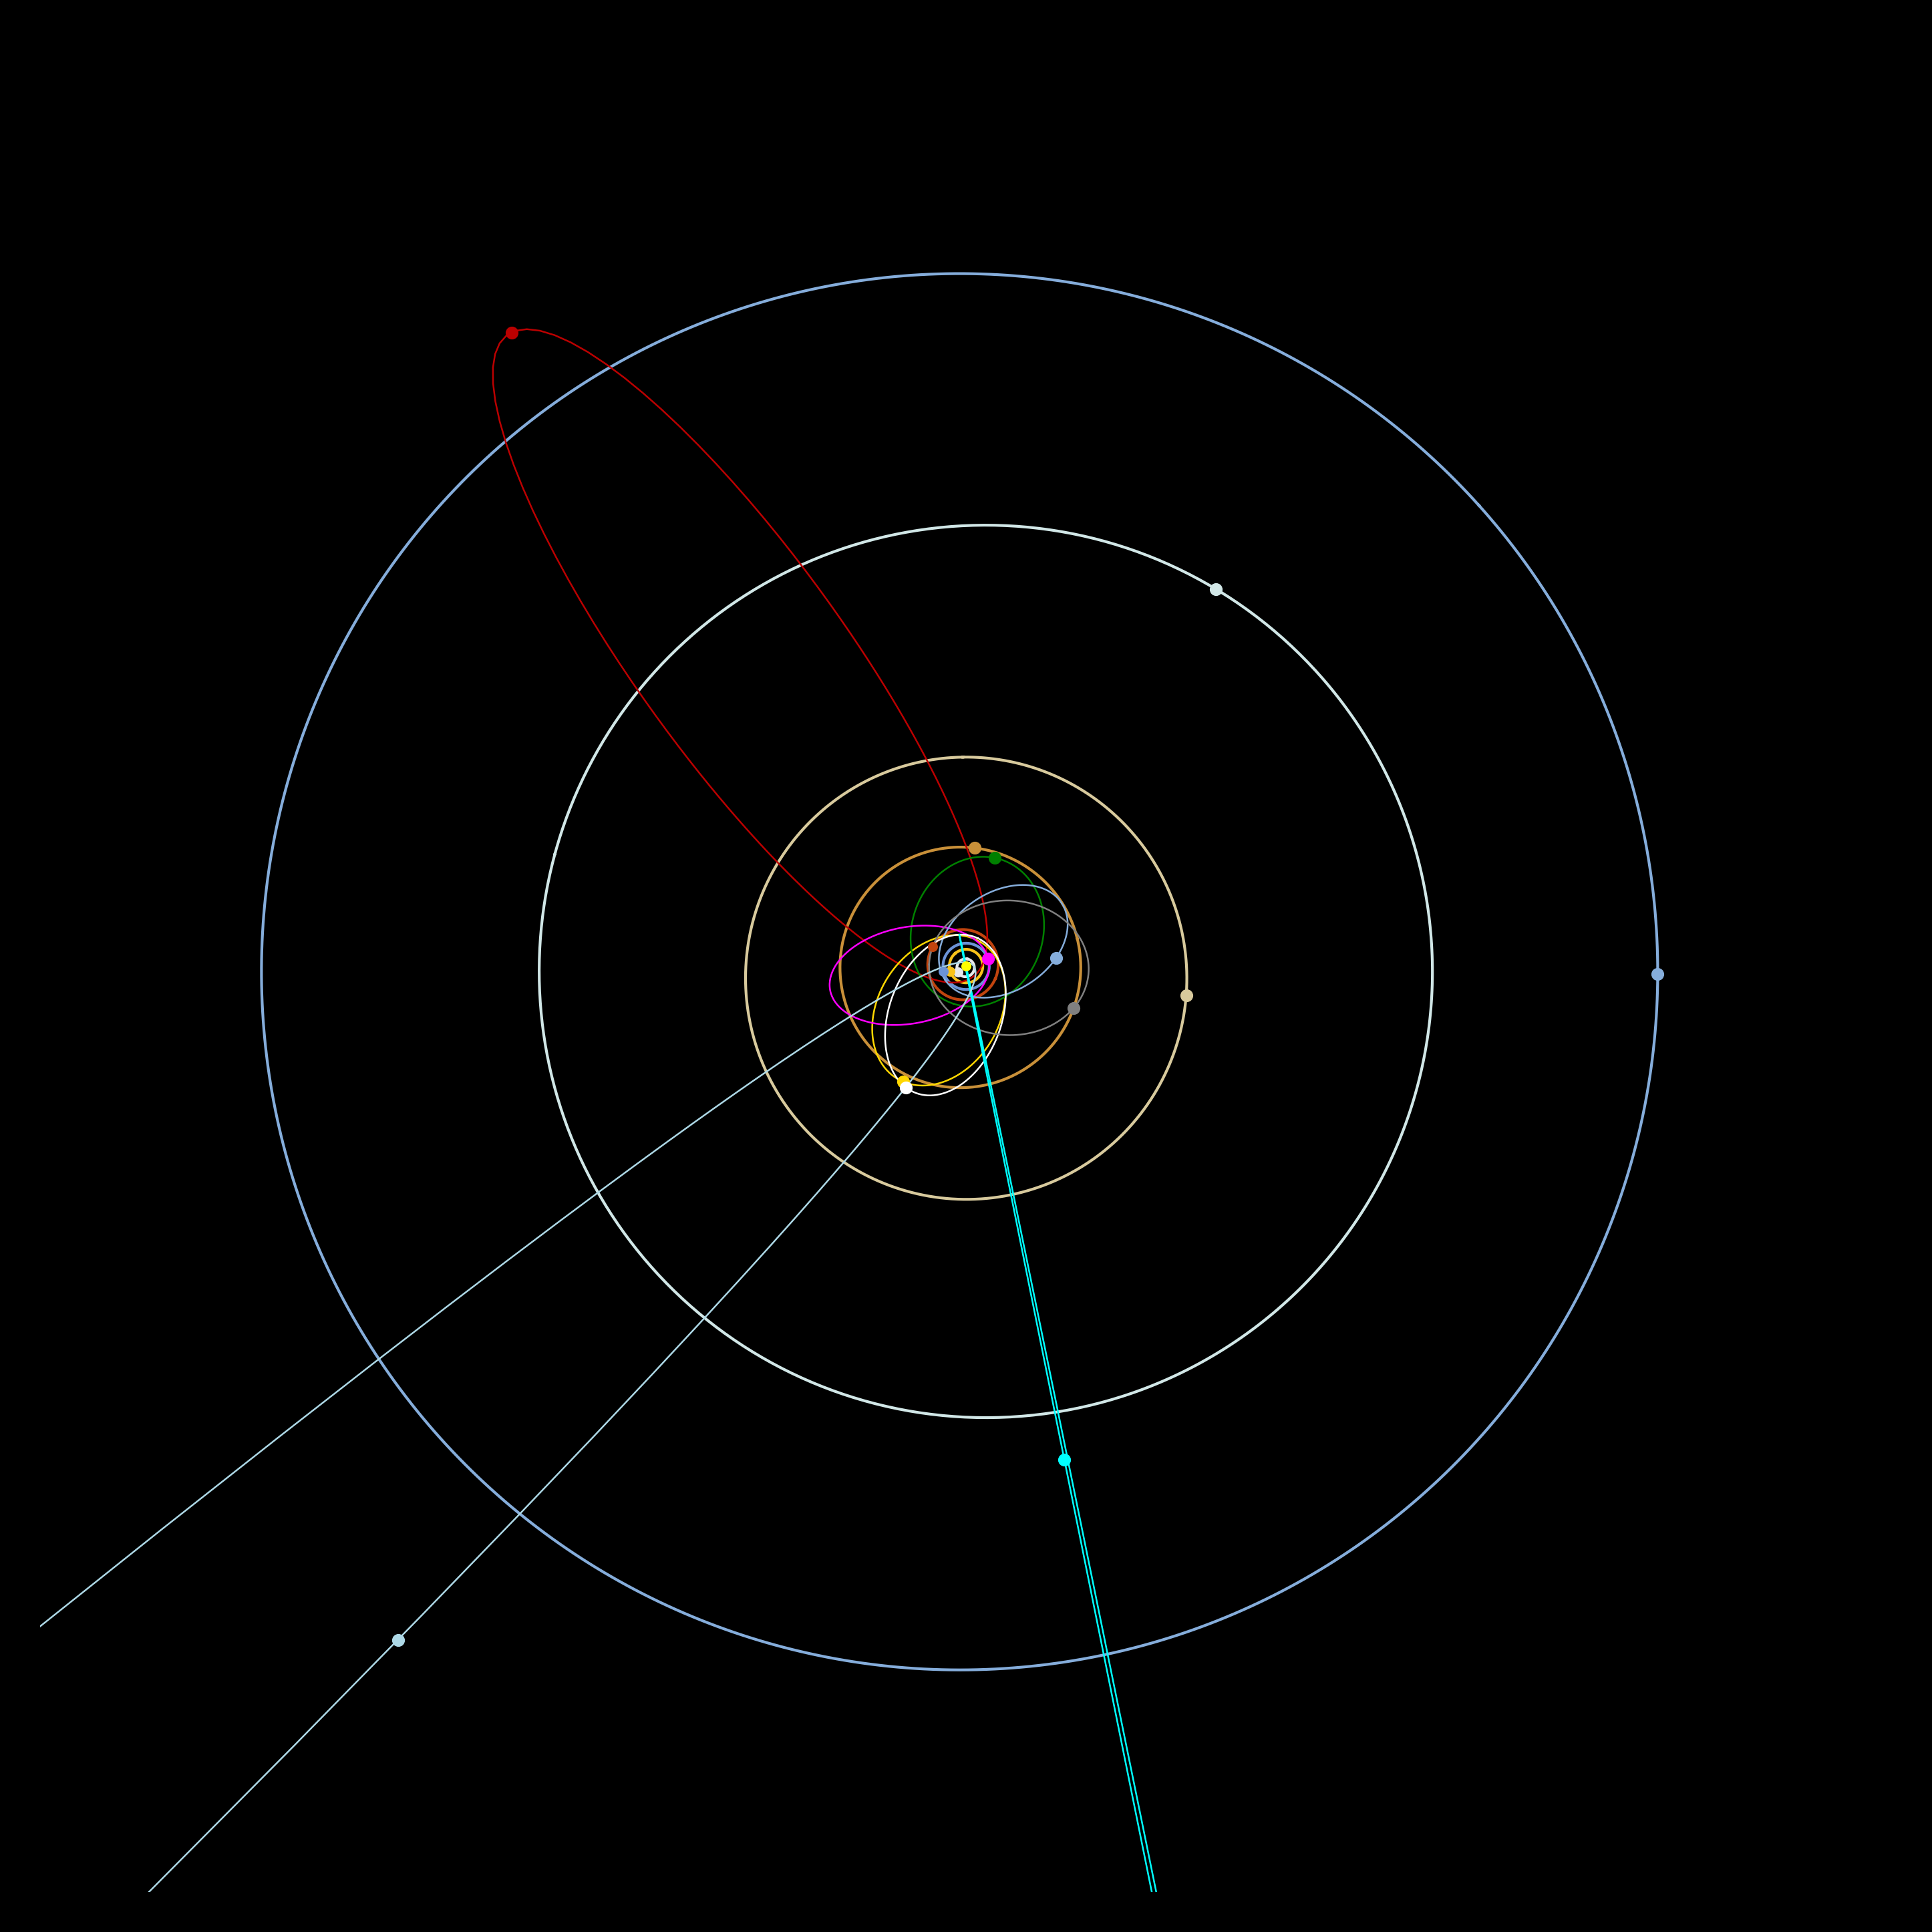

In [78]:
showKey = False
onlyHalley = False

if onlyHalley:
    plotFile = f"Comets_XY_Halley.png"
    bodyList = ['1P/Halley','Pluto']
    aMax = 45.00
else:
    plotFile = f"Comets_XY_{dateTag}.png"
    bodyList = comets
    aMax = 40.00

plt.style.use('dark_background')

fig,ax = plt.subplots(figsize=(wInches,hInches),dpi=dpi)
    
ax.tick_params('both',length=6,width=lwidth,which='major',direction='in',top='on',right='on')
ax.tick_params('both',length=3,width=lwidth,which='minor',direction='in',top='on',right='on')

# Limits

ax.set_xlim(-aMax,aMax)
ax.set_xticks([])
ax.set_ylim(-aMax,aMax)
ax.set_yticks([])
ax.set_axis_off()

ax.set_aspect(True)

# Planet orbits

for body in planets:
    if body in outer:
        pms = 2
        olw = 0.5
    else:
        pms = 1.5
        olw = 0.5
    ax.plot(xOrb[body],yOrb[body],'-',lw=olw,color=colors[body],zorder=9)
    ax.plot(xP[body],yP[body],'o',ms=pms,mfc=colors[body],mec=colors[body],mew=0.3,alpha=1,zorder=10)

# selected comets (see above)

for body in bodyList:
    ax.plot(xOrb[body],yOrb[body],'-',lw=0.3,color=colors[body],zorder=9)
    ax.plot(xP[body],yP[body],'o',ms=2,mfc=colors[body],mec=colors[body],mew=0.3,
            alpha=1,zorder=10,label=body)
    
# and the sun

ax.plot(0,0,'o',ms=1.5,mfc='yellow',mec='yellow',mew=0.3,alpha=1,zorder=10)

# identify comets

if showKey:
    leg = ax.legend(loc="lower right",frameon=False,prop={'size':6})
    for handle in leg.legend_handles:
        handle.set_markersize(3)
        handle.set_alpha(1.0)
        
# save hardcopy

plt.savefig(plotFile,bbox_inches='tight',facecolor='black')

plt.show()

### YZ ecliptic plane projection



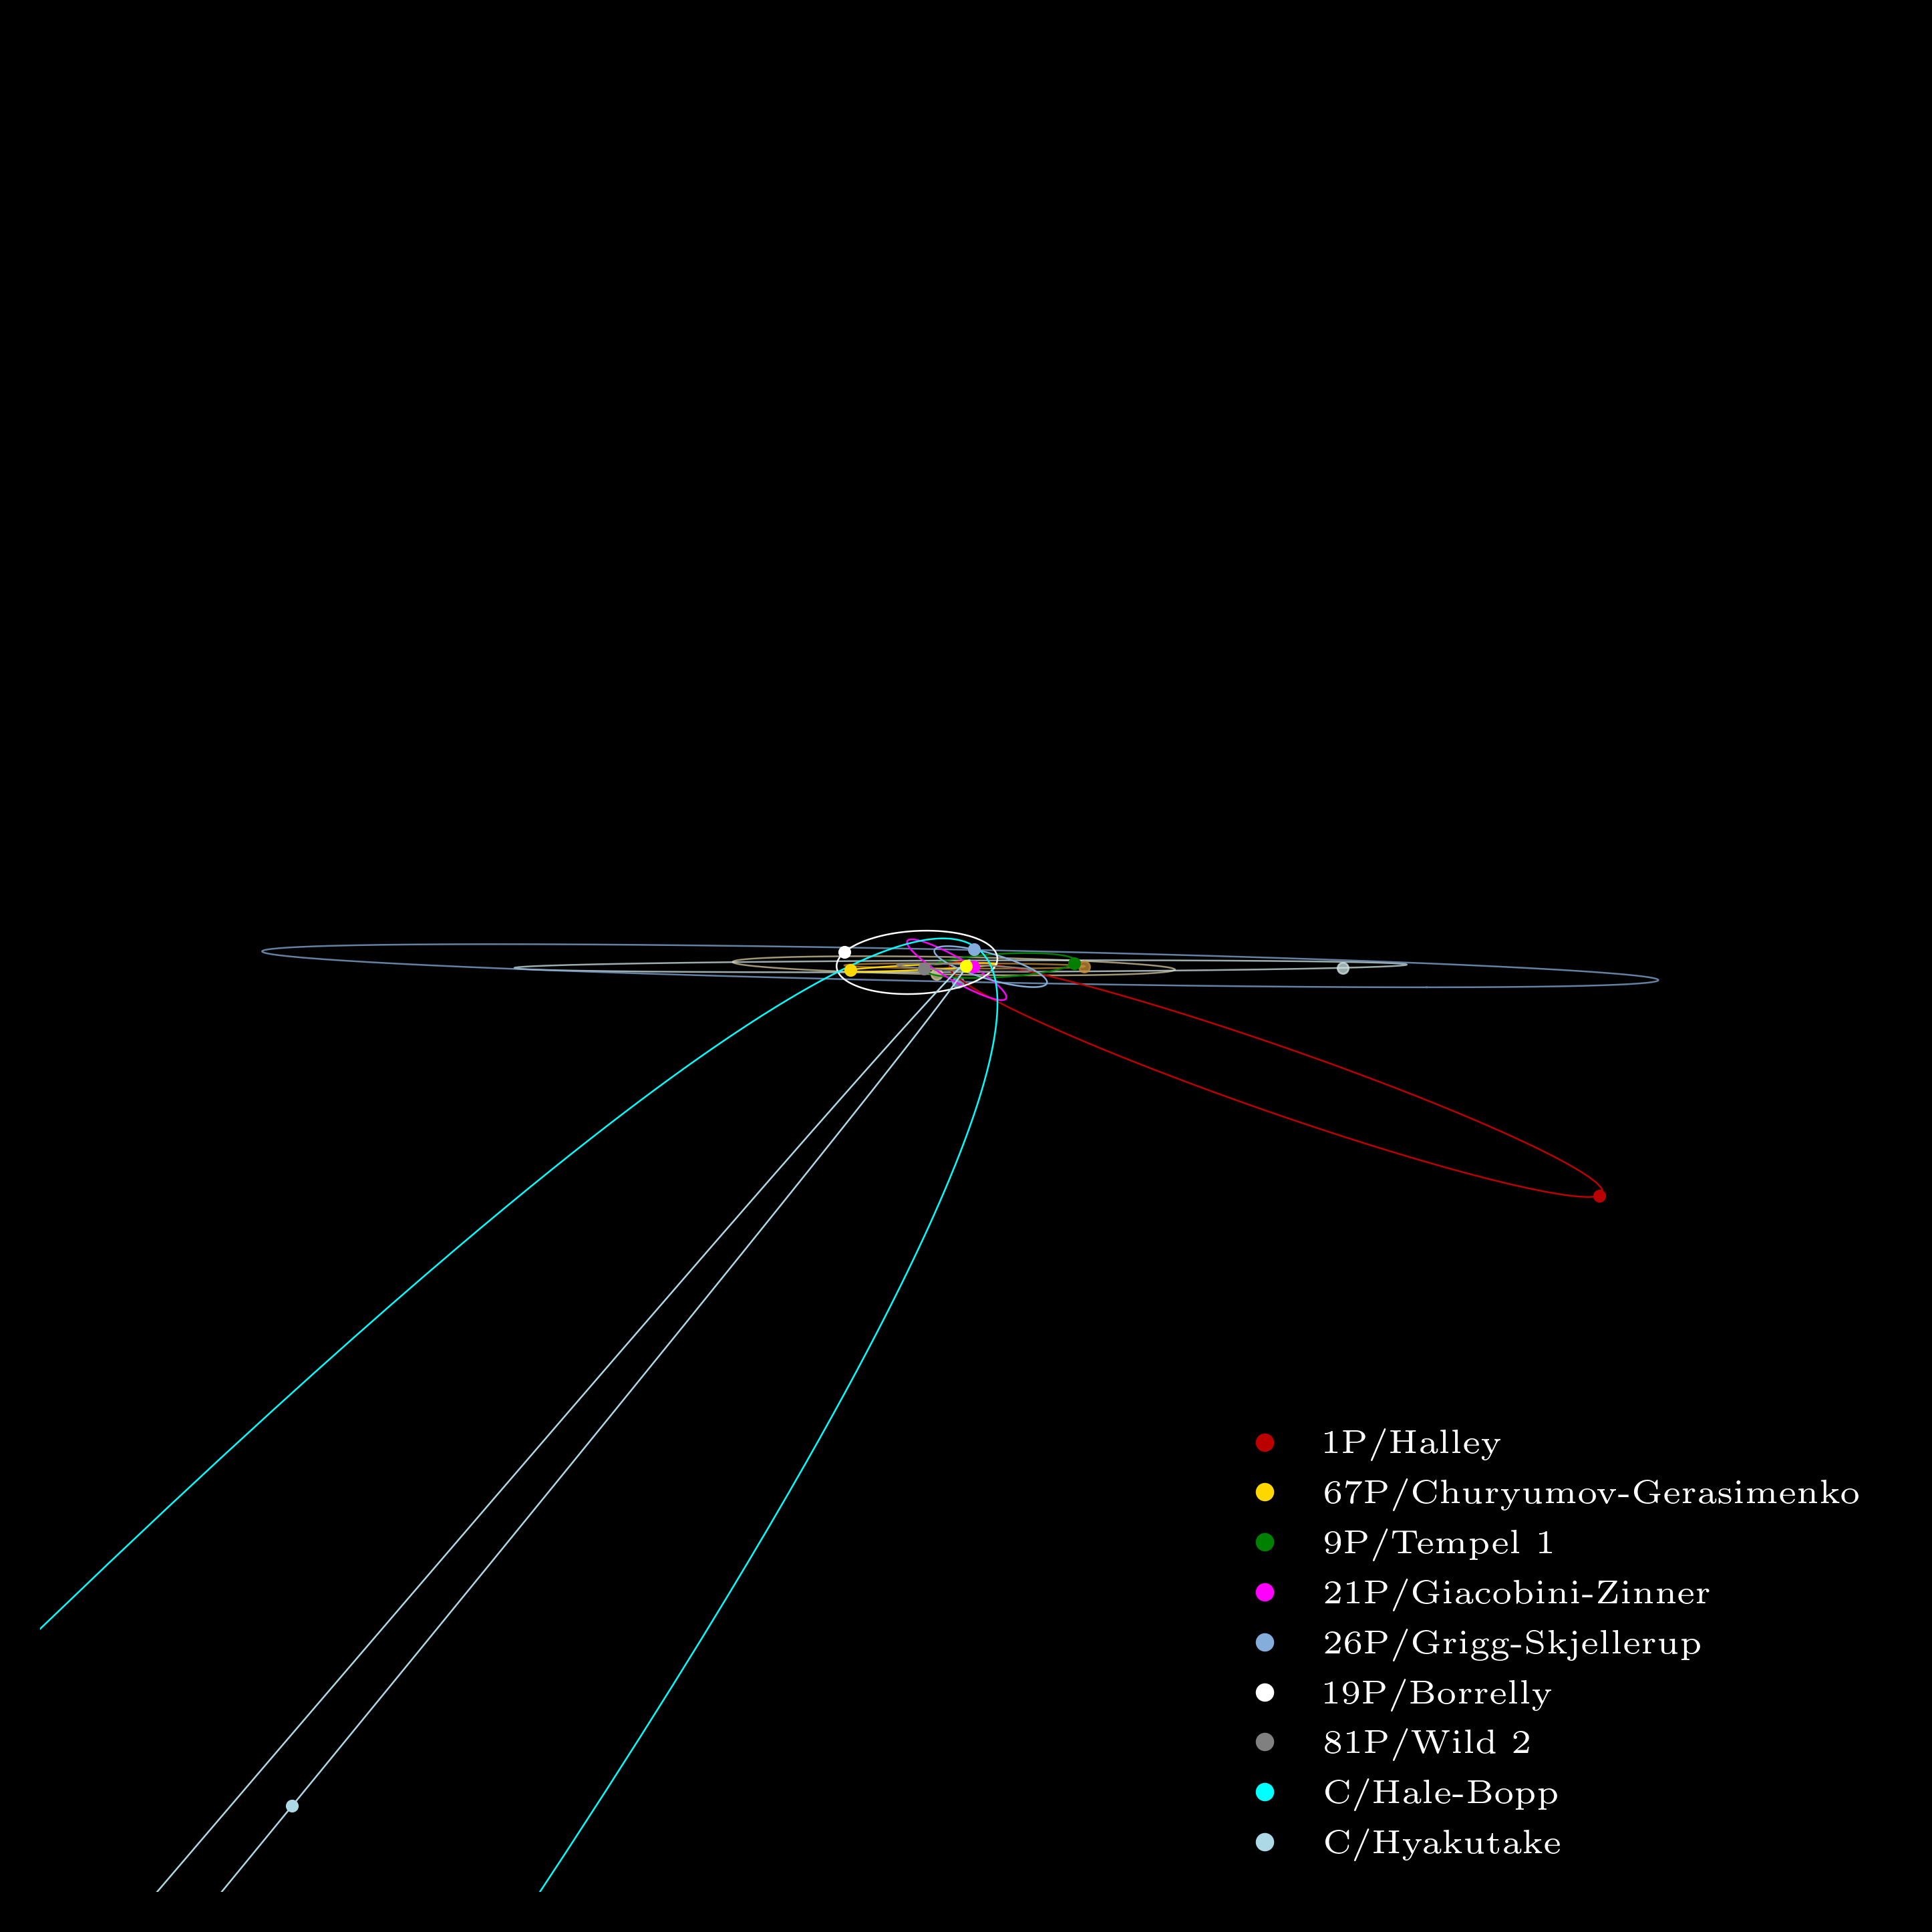

In [79]:
showKey = True
showPlanets = True

onlyHalley = False

if onlyHalley:
    plotFile = f"Comets_YZ_Halley.png"
    bodyList = ['1P/Halley','Pluto']
    axMax = 45.0
    ayMax = 20.0
else:
    plotFile = f"Comets_YZ_{dateTag}.png"
    bodyList = comets
    axMax = 40.0
    ayMax = 40.0

plt.style.use('dark_background')

fig,ax = plt.subplots(figsize=(wInches,hInches),dpi=dpi)
    
ax.tick_params('both',length=6,width=lwidth,which='major',direction='in',top='on',right='on')
ax.tick_params('both',length=3,width=lwidth,which='minor',direction='in',top='on',right='on')

# Limits

ax.set_xlim(-axMax,axMax)
ax.set_xticks([])
ax.set_ylim(-ayMax,ayMax)
ax.set_yticks([])
ax.set_axis_off()

ax.set_aspect(True)

# selected comets

for body in bodyList:
    ax.plot(yOrb[body],zOrb[body],'-',lw=0.3,color=colors[body],zorder=9)
    ax.plot(yP[body],zP[body],'o',ms=2,mfc=colors[body],mec=colors[body],mew=0.3,
            alpha=1,zorder=10,label=body)
    
# and the sun

ax.plot(0,0,'o',ms=2,mfc='yellow',mec='yellow',mew=0.3,alpha=1,zorder=10)

# outer planet orbits or just the ecliptic

if showPlanets:
    for body in outer:
        ax.plot(yOrb[body],zOrb[body],'-',lw=0.3,color=colors[body],alpha=0.75,zorder=6)
        ax.plot(yP[body],zP[body],'o',ms=2,mfc=colors[body],mec=colors[body],mew=0.3,alpha=0.75,zorder=7)
else:
    ax.hlines([0],-30,30,colors=["white"],ls=[":"],lw=0.5,zorder=9)        

if showKey:
    leg = ax.legend(loc="lower right",frameon=False,prop={'size':6})
    for handle in leg.legend_handles:
        handle.set_markersize(3)
        handle.set_alpha(1.0)

# save hardcopy

plt.savefig(plotFile,bbox_inches='tight',facecolor='black')

plt.show()